In [ ]:
import os

total = 0
has_model = 0
no_model_paths = []
for root, dirs, files in os.walk("/local/scratch/carlyn.1/dna/training_output/base"):
    if len(files) > 0:
        total += 1
        if "model.pt" in files:
            has_model += 1
        else:
            no_model_paths.append(root)

print(f"Out of {total} training runs, {has_model} have models.")
print("Those paths include: ")
print("\n".join(no_model_paths))

In [ ]:
from multiprocessing import Pool
import os
import dataclasses
import torch
from tqdm.auto import tqdm
from pathlib import Path
from torch.utils.data import DataLoader
from captum.attr import LRP
import numpy as np
from scipy.stats import pearsonr

from gtp.configs.loaders import load_configs
from gtp.configs.project import GenotypeToPhenotypeConfigs
from gtp.dataloading.data_collectors import load_training_data
from gtp.dataloading.datasets import GTP_Dataset
from gtp.dataloading.path_collectors import get_experiment_directory
from gtp.models.net import SoyBeanNet
from gtp.options.process_attribution import ProcessAttributionOptions
from gtp.evaluation import get_lrp_attr

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


def _process_chromosome(
    configs: GenotypeToPhenotypeConfigs,
    options: ProcessAttributionOptions,
    chromosome: int = None,
):
    if chromosome is not None:
        options = dataclasses.replace(options)
        options.chromosome = chromosome

    experiment_dir = get_experiment_directory(
        configs.io,
        species=options.species,
        wing=options.wing,
        color=options.color,
        chromosome=options.chromosome,
        exp_name=options.exp_name,
    )

    if not os.path.exists(experiment_dir):
        print(
            f"{experiment_dir} does not exist. Unable to process chromosome {options.chromosome}"
        )
        return

    # TODO: load the saved data instead of recomputing

    train_data, val_data, test_data = load_training_data(configs, options)
    num_vcfs = train_data[0].shape[1]
    model = SoyBeanNet(
        window_size=num_vcfs,
        num_out_dims=options.out_dims,
        insize=options.insize,
        hidden_dim=options.hidden_dim,
        drop_out_prob=options.drop_out_prob,
    )

    model.load_state_dict(torch.load(experiment_dir / "model.pt", weights_only=True))
    model = model.cuda()
    model.eval()

    train_dataset = GTP_Dataset(*val_data)

    train_dataloader = DataLoader(
        train_dataset, batch_size=options.batch_size, num_workers=options.num_workers
    )

    attribution_data = get_lrp_attr(
        model, train_dataloader, target=0, verbose=True, num_processes=8
    )
    return attribution_data


cfgs: GenotypeToPhenotypeConfigs = load_configs(
    config_path=Path("../../configs/default.yaml")
)
opts: ProcessAttributionOptions = ProcessAttributionOptions(
    species="erato",
    color="color_3",
    chromosome=18,
    wing="forewings",
    exp_name="base",
    batch_size=16,
)

attribution_data = _process_chromosome(configs=cfgs, options=opts)

Calculating LRP Attributions: 0it [00:00, ?it/s]

Processing Genotype data:   0%|          | 0/1646818 [00:00<?, ?it/s]

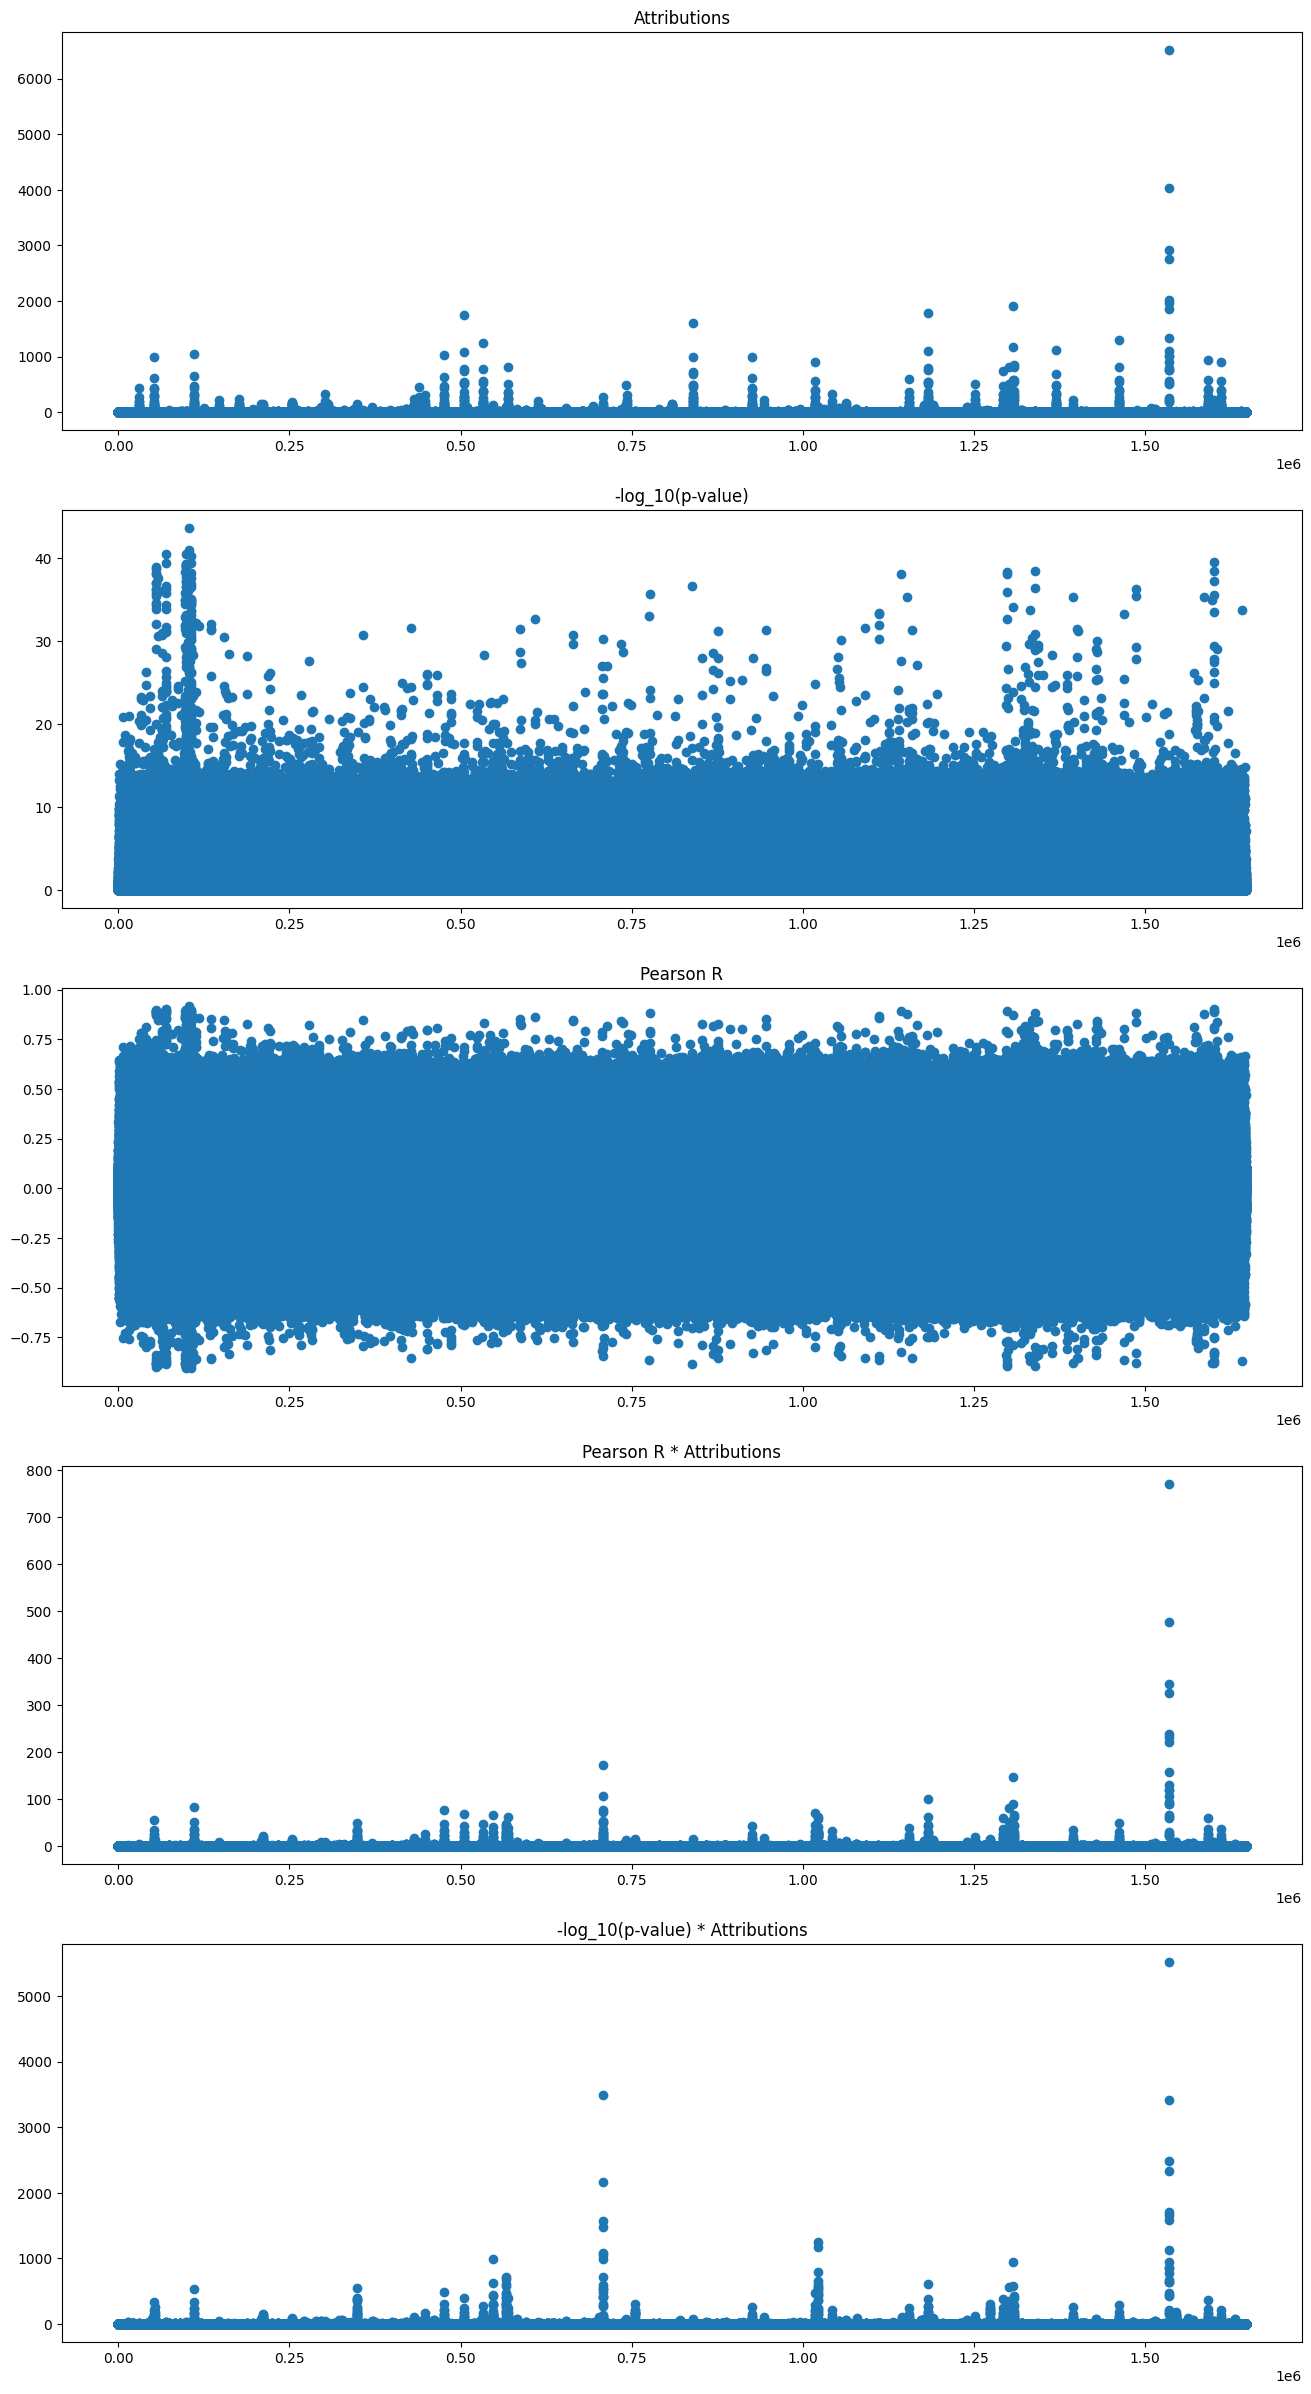

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(len(attribution_data))
y_attributions = [x[0] for x in attribution_data]
y_neg_log_pvalue = [-np.log(x[2]) for x in attribution_data]
y_pearson_r = [x[1] for x in attribution_data]

rows = 5
fig, axs = plt.subplots(rows, 1, figsize=(16, 6 * rows))
axs[0].scatter(x, y_attributions)
axs[0].set_title("Attributions")
axs[1].scatter(x, y_neg_log_pvalue)
axs[1].set_title("-log_10(p-value)")
axs[2].scatter(x, y_pearson_r)
axs[2].set_title("Pearson R")
axs[3].scatter(x, np.abs(y_pearson_r) * y_attributions)
axs[3].set_title("Pearson R * Attributions")
axs[4].scatter(x, y_neg_log_pvalue * y_attributions)
axs[4].set_title("-log_10(p-value) * Attributions")

plt.show()